### Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

! tar -zxvf /content/drive/MyDrive/Uni/DeepRiccy/refcocog.tar.gz
! pip3 install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
!pip install rouge-metric

local_path = '/content/refcocog/images/'
local_annotations = '/content/refcocog/annotations/'

Streaming output truncated to the last 5000 lines.
./refcocog/images/COCO_train2014_000000575305.jpg
./refcocog/images/COCO_train2014_000000509534.jpg
./refcocog/images/COCO_train2014_000000150074.jpg
./refcocog/images/COCO_train2014_000000538291.jpg
./refcocog/images/COCO_train2014_000000483045.jpg
./refcocog/images/COCO_train2014_000000206385.jpg
./refcocog/images/COCO_train2014_000000049275.jpg
./refcocog/images/COCO_train2014_000000028276.jpg
./refcocog/images/COCO_train2014_000000128434.jpg
./refcocog/images/COCO_train2014_000000320788.jpg
./refcocog/images/COCO_train2014_000000419396.jpg
./refcocog/images/COCO_train2014_000000433336.jpg
./refcocog/images/COCO_train2014_000000567523.jpg
./refcocog/images/COCO_train2014_000000451554.jpg
./refcocog/images/COCO_train2014_000000439855.jpg
./refcocog/images/COCO_train2014_000000044594.jpg
./refcocog/images/COCO_train2014_000000194276.jpg
./refcocog/images/COCO_train2014_000000272463.jpg
./refcocog/images/COCO_train2014_000000485426.jpg

### PC

In [ ]:
local_path = './refcocog/images/' 
local_annotations = './refcocog/annotations/' 

# Baseline

In [3]:
#imports

import json
import pickle
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from pkg_resources import packaging
import clip
import numpy as np

import os
import skimage
import IPython.display

from collections import OrderedDict
import torch

import rouge_metric

In [4]:
from sklearn.metrics import jaccard_score

#define evaluation metrics for bounfing boxes
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    if interArea == 0:
        return 0
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

#define jacard index for images that are not the same dimensions
def jacard_index(image1, image2):
    image1 = image1.resize((image2.size[0], image2.size[1]))
    image1 = np.array(image1)
    image2 = np.array(image2)
    image1 = image1.flatten()
    image2 = image2.flatten()
    return jaccard_score(image1, image2, average='macro')


In [5]:
#define evaluation metrics for the model as a class that can be updated on each iteration
class Metrics:
    def __init__(self):
        self.jaccard = []
        self.iou = []

    def update(self, bbox_y, bbox_gt, img1, img2):
        self.jaccard.append(jacard_index(img1, img2))
        self.iou.append(iou(bbox_y, bbox_gt))

    def get(self):
      print('get')
      return np.mean(self.jaccard), np.mean(self.iou)

    def __str__(self):
      return "Jaccard: " + str(self.jaccard) + " IoU: " + str(self.iou)


In [6]:
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append
    
    return string

In [7]:
def convert_bbox(bbox, img):
  x1, y1, width, height = bbox
  x2, y2 = x1 + width, y1 + height

  # Verifica se le coordinate superano le dimensioni dell'immagine
  if x1 < 0 or y1 < 0 or x2 > img.width or y2 > img.height:
      print("Bounding box fuori dai limiti dell'immagine!")
  else:
    return x1, y1, x2, y2

## Dataset

In [8]:
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path_json = path_json
        self.path_pickle = path_pickle
        self.train = train

        #load images and annotations
        with open(self.path_json) as json_data:
            data = json.load(json_data)
            self.ann_frame = pd.DataFrame(data['annotations'])
            self.ann_frame = self.ann_frame.reset_index(drop=False)


        #load annotations
        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        #separate each sentence in dataframe
        self.refs_frame = self.refs_frame.explode('sentences')

        self.refs_frame = self.refs_frame.reset_index(drop=False)

        self.size = self.refs_frame.shape[0]

        self.dataset = pd.merge(self.refs_frame, self.ann_frame, left_on='ann_id', right_on='id')
        self.dataset = self.dataset.drop(columns=['segmentation', 'id', 'category_id_y','ref_id', 'index_x', 'iscrowd', 'image_id_y', 'image_id_x', 'category_id_x', 'ann_id', 'sent_ids', 'index_y', 'area'])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.dataset.iloc[idx]

    def get_annotation(self, idx):
      return self.ann_frame.iloc[idx]
    
    def get_imgframe(self, idx):
      return self.img_frame.iloc[idx]


In [9]:
#test dataset

dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")

print(len(dataset))
print(len(dataset.dataset))


95010
95010


In [10]:
print(dataset[0]['sentences'])

{'tokens': ['the', 'man', 'in', 'yellow', 'coat'], 'raw': 'the man in yellow coat', 'sent_id': 8, 'sent': 'the man in yellow coat'}


In [11]:
dataset.dataset

,split,sentences,file_name,bbox
0,test,"{'tokens': ['the', 'man', 'in', 'yellow', 'coa...",COCO_train2014_000000380440_491042.jpg,"[374.31, 65.06, 136.04, 201.94]"
1,test,"{'tokens': ['skiier', 'in', 'red', 'pants'], '...",COCO_train2014_000000380440_491042.jpg,"[374.31, 65.06, 136.04, 201.94]"
2,test,"{'tokens': ['there', 'is', 'red', 'colored', '...",COCO_train2014_000000419645_398406.jpg,"[93.95, 83.29, 504.61, 290.57]"
3,test,"{'tokens': ['a', 'shiny', 'red', 'vintage', 'p...",COCO_train2014_000000419645_398406.jpg,"[93.95, 83.29, 504.61, 290.57]"
4,test,"{'tokens': ['a', 'apple', 'desktop', 'computer...",COCO_train2014_000000478885_124383.jpg,"[338.8, 82.19, 147.34, 157.37]"
...,...,...,...,...
95005,train,"{'tokens': ['the', 'larger', 'banana', 'is', '...",COCO_train2014_000000003518_1042682.jpg,"[141.7, 20.68, 359.02, 144.57]"
95006,train,"{'tokens': ['a', 'guy', 'in', 'black', 'jacket...",COCO_train2014_000000302199_473946.jpg,"[141.34, 86.71, 115.33, 288.75]"
95007,train,"{'tokens': ['the', 'man', 'in', 'the', 'dark',...",COCO_train2014_000000302199_473946.jpg,"[141.34, 86.71, 115.33, 288.75]"
95008,train,"{'tokens': ['a', 'person', 'in', 'red', 'dress...",COCO_train2014_000000573297_472971.jpg,"[31.71, 67.03, 352.29, 572.97]"


In [12]:
#test clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

## Model

In [13]:
class VisualGrounding(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding, self).__init__()
        self.local_path = local_path
        self.img_path = img_path
        #initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version , pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)
        
        #define metrics
        self.metrics = Metrics()
        
    
    def forward(self, img_path, sentence):
        max_similarity = 0
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)


        original_img = Image.open(self.local_path+img_path).convert("RGB")

        for i in range(len(yolo_output.xyxy[0])):
            x1 = yolo_output.xyxy[0][i][0].numpy()
            x1 = np.rint(x1)
            y1 = yolo_output.xyxy[0][i][1].numpy()
            y1 = np.rint(y1)
            x2 = yolo_output.xyxy[0][i][2].numpy()
            x2 = np.rint(x2)
            y2 = yolo_output.xyxy[0][i][3].numpy()
            y2 = np.rint(y2)

            img_cropped = original_img.crop((x1, y1, x2, y2))

            img = self.preprocess(img_cropped).unsqueeze(0)

            image_imput = torch.tensor(img)
            
            text = clip.tokenize([sentence])

            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()
                text_features = self.clip.encode_text(text).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

            if similarity > max_similarity:
                max_similarity = similarity
                max_image = img_cropped
                max_bbox = yolo_output.xyxy[0][i]

            return max_bbox, max_image
        
    def evaluate(self, img_path, sentence, gt, original_img):
      bbox = convert_bbox(gt, original_img)
      gt_crop = original_img.crop(bbox)
      prediction_bbox, prediction_img = self.forward(img_path, sentence)
      self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)

    def get_metrics(self):
        return self.metrics.get()
          
        

In [14]:
model = VisualGrounding('yolov5x','ViT-B/32', local_path, local_annotations)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-2 Python-3.10.11 torch-2.0.0+cu118 CPU



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [20]:
local_path = '/content/refcocog/images/'
local_annotations = '/content/refcocog/annotations/'
input = dataset[77]

image_path = split_string(input["file_name"])
sentence = input["sentences"]["raw"]
print(image_path, sentence )
#model.forward(image_path, sentence)



COCO_train2014_000000028038.jpg Couch behind the person wearing headphones.


tensor([227.09726, 287.59210, 313.82047, 487.63385,   0.88588,  48.00000])
the middle piece of the chicken roll up


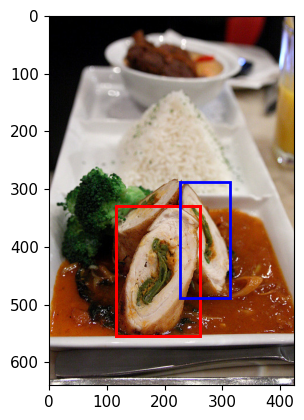

In [36]:
input = dataset[553]

image_path = split_string(input["file_name"])
sentence = input["sentences"]["raw"]
original_img = Image.open(local_path+image_path).convert("RGB")
gt = input["bbox"]
x1, y1, width, height = gt
x2, y2 = x1 + width, y1 + height

# Verifica se le coordinate superano le dimensioni dell'immagine
if x1 < 0 or y1 < 0 or x2 > original_img.width or y2 > original_img.height:
    print("Bounding box fuori dai limiti dell'immagine!")
else:
    # Ritaglia l'immagine usando le coordinate della bounding box
    crop = original_img.crop((x1, y1, x2, y2))    
    # Mostra l'immagine originale con la bounding box
    %matplotlib inline
    plt.imshow(original_img)
    plt.gca().add_patch(plt.Rectangle((x1, y1), width, height, fill=False, edgecolor='red', linewidth=2))
    bbox, img = model.forward(image_path, sentence)
    plt.gca().add_patch(plt.Rectangle((x1, y1), width, height, fill=False, edgecolor='red', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='blue', linewidth=2))
    print(bbox)
    print(sentence)
    plt.show()


In [37]:
#evaluation of the model
for i in range(len(dataset)):
    input = dataset[i]
    image_path = split_string(input["file_name"])
    sentence = input["sentences"]["raw"]
    gt = input["bbox"]
    original_img = Image.open(local_path+image_path).convert("RGB")
    #print img dimensions and box coordinates
    model.evaluate(image_path, sentence, gt, original_img)
    if i % 100 == 0:
        print("Iteration: ", i)
        print(model.get_metrics())
        

Iteration:  0
get
(0.0032757957925080993, 0.0)


KeyboardInterrupt: ignored

In [77]:

    #pass image into yolo
    yolo = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)

    input = dataset[55]

    image_path = split_string(input["file_name"])

    yolo_output = yolo(local_path+image_path)

    model, preprocess = clip.load("ViT-B/32")
    model.eval()
    #pass each bounding box segmented image into clip with the sentence

    sentence = input["sentences"]["raw"]
    print(sentence)

    max_similarity = 0
    max_image = None
    max_bbox = None

    original_img = Image.open(local_path+image_path).convert("RGB")    

    for i in range(len(yolo_output.xyxy[0])):

        x1 = yolo_output.xyxy[0][i][0].numpy()
        x1 = np.rint(x1)
        y1 = yolo_output.xyxy[0][i][1].numpy()
        y1 = np.rint(y1)
        x2 = yolo_output.xyxy[0][i][2].numpy()
        x2 = np.rint(x2)
        y2 = yolo_output.xyxy[0][i][3].numpy()
        y2 = np.rint(y2)

        img_cropped = original_img.crop((x1, y1, x2, y2))

        img = preprocess(img_cropped).unsqueeze(0)
        image_imput = torch.tensor(img)
        
        text = clip.tokenize([sentence])

        with torch.no_grad():
            image_features = model.encode_image(img).float()
            text_features = model.encode_text(text).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

        if similarity > max_similarity:
            max_similarity = similarity
            max_image = img_cropped
            max_bbox = yolo_output.xyxy[0][i]


        print(similarity) 
    yolo_output.show()


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-2 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


KeyboardInterrupt: ignored